# Variational Autoencoders (VAEs)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


Variational autoencoder (VAE) เป็น autoencoder ที่มีข้อมูลใน latent vector ถูกทำให้กระจายตัวแบบ Gaussian distribution ซึ่งเป็น normal distribution ที่มีค่าเฉลี่ยเท่ากับ 0 และ variance เท่ากับ 1 ($\mathcal{N}(0, 1)$)

## Architecture

- VAE มีโครงสร้างเหมือนกับ autoencoder ทั่วไป ยกเว้น latent space จะถูกทำให้กระจายตัวแบบ Gaussian distribution
- มี 2 loss ที่ต้อง minimise ได้แก่
    - <b>Generation loss</b> คือความต่างระหว่าง output กับ input
    
    $$\text{Generation Loss} = \text{diff}(x, \hat{x})$$<br />

    - <b>Latent loss</b> คือความต่างระหว่างการการจายตัวของ latent vector ใน latent space ($\mathcal{N}(\mu, \sigma^2)$) กับกระจายตัวแบบ Gaussian distribution ความต่างของ probability distribution วัดได้โดยใช้ <b>Kullback-Leibner (KL) Divergence</b>

\begin{align*}
    \text{Latent Loss} &= \text{KL}(\mathcal{N}(\mu, \sigma^2 I)\;||\;\mathcal{N}(0, I)) \\
    &= \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
\end{align*}

<img src="../images/vae.png" width="500" /> <br />

- Latent space ที่ได้จาก VAE จะมี region ต่าง ๆ อยู่ติดกันมากกว่า ทำให้ interpolate ง่ายกว่า โอกาสที่ unseen data ไม่อยู่ใน region ใด ๆ เลยจึงมีน้อย

<img src="../images/latent_spaces.png" width="700" /> <br />

## Training VAEs

In [4]:
# Download the training MNIST dataset and create a data loader for it
data = DataLoader(
    MNIST('../data', train=True, download=True, transform=ToTensor()),
    batch_size=128,
    shuffle=True
)

In [10]:
# Create an encoder and a decoder to be used in a VAE
class Encoder(nn.Module):
    """Encoder with 2 fully-connected layers"""
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(784, 512)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()

    def forward(self, x):
        '''
        Parameters
        ----------
        x : float

            Input image

        '''
        x = x.flatten(start_dim=1)  # Reshape the input into a vector (nD to 1D)
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        return x

class Decoder(nn.Module):
    """Decoder with 2 fully-connected layers"""
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(256, 512)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 784)
        self.activation2 = nn.Sigmoid()

    def forward(self, z):
        '''
        Parameters
        ----------
        z : float

            Latent variable

        '''
        z = self.activation1(self.layer1(z))
        z = self.activation2(self.layer2(z))
        z = z.reshape((-1, 1, 28, 28))  # Reshape the vector into a (28x28) grayscale image
        return z

In [11]:
# Create a VAE
class VAE(nn.Module):
    def __init__(self, dims_latent):
        '''
        Parameters
        ----------
        dims_latent : int

            The dimension of (the number of nodes in) the mean-field gaussian latent variable.

        '''
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        self.layerMu = nn.Linear(256, dims_latent)
        self.layerSig = nn.Linear(256, dims_latent)
        self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

        self.latentOut = nn.Linear(dims_latent, 256)
        self.activationOut = nn.ReLU()

    def pass_through_latent_space(self, x):
        mu = self.layerMu(x)  # Turn the output of the Encoder into Mu
        sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures the positivity for Sigma
        z = mu + sigma * self.distribution.sample(mu.shape).to(device)
        latent_loss = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z, latent_loss

    def forward(self, x):
        x = self.encoder(x)
        z, latent_loss = self.pass_through_latent_space(x)
        z = self.activationOut(self.latentOut(z))
        x_hat = self.decoder(z)
        return x_hat, latent_loss

In [12]:
# Define a function for training the VAE
def train(vae, data, epochs=10):
    optimizer = torch.optim.Adam(vae.parameters())
    for epoch in range(epochs):
        for batch, label in data:
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, latent_loss = vae(batch)
            generation_loss = ((batch - x_hat)**2).sum()  # L2 loss
            loss = generation_loss + latent_loss  
            loss.backward()
            optimizer.step()
    return vae  # Return the trained VAE

In [17]:
# Define functions for plotting latent vectors
def plot_2D_latent_vectors(vae, data, num_batches=100):
    '''Plot the latent vectors for images'''
    for n, (batch, label) in enumerate(data):
        batch = batch.to(device)
        z, _ = vae.pass_through_latent_space(vae.encoder(batch))  # Get latent vectors by passing the batch
                                                                  # through the encoder and the latent input layer
        z = z.to('cpu').detach().numpy()  # Send to CPU
        # Plot latent vectors and colour them by labels
        plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10')
        if n > num_batches:  # stop after n > maximum number of batches
            plt.colorbar()
            break

def plot_2D_single_latent_vector(vae, image):
    '''Plot the latent vector for a single image'''
    image = image.to(device)
    z, _ = vae.pass_through_latent_space(vae.encoder(image))  # Get the latent vector by passing the image
                                                              # through the encoder and the latent input layer
    z = z.to('cpu').detach().numpy()  # Send to CPU
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Plot the latent vector

In [14]:
# Define a function to plot an image generated by an autoencoder given a latent vector (z)
def plot_output(autoencoder, z):
    z_out = autoencoder.activationOut(autoencoder.latentOut(z))
    img = autoencoder.decoder(z_out).to('cpu').detach().numpy()[0, 0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)

In [19]:
# Initialise a VAE and train it
vae = VAE(dims_latent=2).to(device)
vae = train(vae, data, 10)

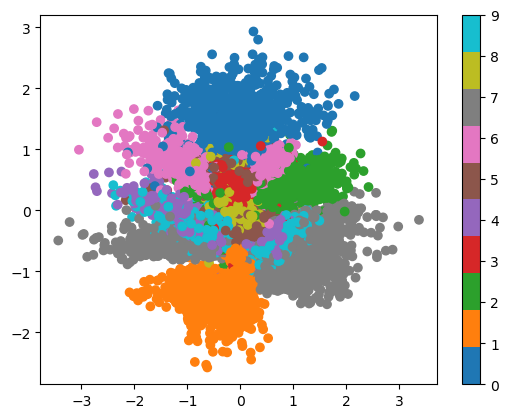

In [20]:
# Plot latent vactors produced by the trained VAE
plot_2D_latent_vectors(vae, data)

In [21]:
# Get the next iteration from the data loader
batch, labels = next(iter(data))

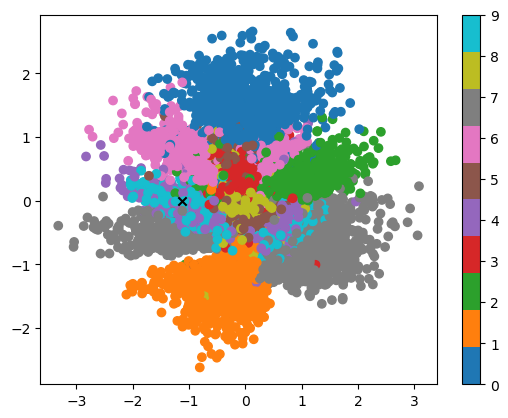

In [23]:
# Plot latent vactors produced by the trained VAE
# and the latent vector for the first image in the batch
image = batch[0]
plt.figure()
plot_2D_latent_vectors(vae, data)
plot_2D_single_latent_vector(vae, image)

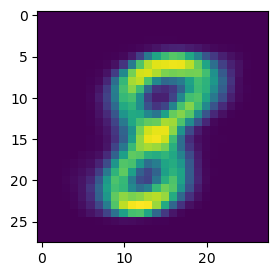

In [24]:
# Plot an output image generated by the trained VAE given a latent vector z
# We can see from the latent space plotted above that
# a latent vector of (0, 0) will give an image with a label of 8
z = torch.tensor([0, 0]).to(device).float()
plot_output(vae, z)